# Prejudice Remover Regularizer

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-preparation)
3. [Classifier network](#3.-Classifier-network)
	*  [Model Fairness for Classifier Network](#Model-Fairness-for-Classifier)
4. [Prejudice Remover Regularizer](#4.-Prejudice-Remover-Regularizer)
	* [Model Fairness: with PRR](#Model-Fairness:-with-PRR)
5. [Summary](#5.-Summary)
6. [References](#References)

## 1. Introduction 

So far, we have published a series of bias identification and mitigation tutorials in NNabla. They include pre-processing, in-processing and post-processing techniques. 

In this tutorial, we give an overview of yet another in-processing technique for bias mitigation in predictive models. In-processing techniques involve modification of learning algorithms to address discrimination during the model training phase. [Classification with Fairness Constraints](https://arxiv.org/abs/1806.06055), [Prejudice Remover Regularizer](https://link.springer.com/content/pdf/10.1007%2F978-3-642-33486-3_3.pdf) and [Adversarial Debiasing](https://arxiv.org/pdf/1801.07593.pdf) are among the popular in-processing bias mitigation techniques proposed in academic literature. Adversarial debiasing technique is explained earlier. So, we will show how to mitigate bias in a predictive model using the `Prejudice Remover Regularizer` technique in this tutorial.

Before we go into detailed explanation, here is a sneak peek into the steps involved in the process:

### Preparation
Let's start by installing NNabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you want to run this tutorial in Google Colab, please make sure to set Runtime setting to GPU. It can be set up from the top menu (Runtime → change runtime type). Click **Connect** on the top right-hand side of the screen before you start.

In [1]:
# Preparation
# May show warnings for newly imported packages if run in Colab default python environment.
# Please click the `RESTART RUNTIME` to run the following script correctly.
# The error message of conflicts is acceptable.
!git clone https://github.com/sony/nnabla-examples.git
!pip install nnabla-ext-cuda116

In [ ]:
%cd nnabla-examples/responsible_ai/prejudice_remover_regularizer

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/Prejudice_Remover_Regularizer_workflow_diagram.png')
cv2_imshow(img)

As illustrated in the picture, we will train a model to make income level predictions, analyze model fairness and then show how Prejudice Remover Regularizer training can be employed to make the model fair if fairness metric/score is not up to the mark.

At first, import all the necessary python libraries used in all the steps.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import nnabla as nn
from nnabla.logger import logger
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
from nnabla.utils.data_iterator import data_iterator
from nnabla.utils.data_source import DataSource
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Markdown

from utils import *

2022-05-17 11:27:48,595 [nnabla][INFO]: Initializing CPU extension...


## 2. Data preparation

Before training the model, we need to parse [adult](https://archive.ics.uci.edu/ml/datasets/Adult) dataset and categorize it into three categories: features, targets and sensitive attributes. Features contain input attributes, targets contain binary class labels (income range) and sensitive attributes are those for which we want the prediction to be fair (race, sex, etc.).

Note: sensitive attributes race and sex are not "features".

Next, we split the data into train and test sets. Features are scaled using "standard scaling" method.

In [3]:
X, y, Z = load_adult_dataset()
Z = Z.drop(['race'], axis = 1)

# split into train/test set
(X_train, X_test, y_train, y_test,
 Z_train, Z_test) = train_test_split(X, y, Z, test_size=0.3, stratify=y, random_state=7)

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train)
X_test = scale_orig.fit_transform(X_test)

features : 28750 samples, 88 attributes

targets : 28750 samples

sensitives attributes : 28750 samples, 2 attributes

NNabla provides utilities to load data for training. Here, we will use NNabla DataSource and data_iterator.

In [4]:
class dataset(DataSource):
    def __init__(self,features, labels, senstive_attribute, shuffle=False):
        super(dataset, self).__init__(shuffle=shuffle)
        self.x = features
        self.y = labels.reshape(-1, 1)
        self.z = senstive_attribute
        self._size = self.y.size
        self._variables = ('x', 'y', 'z')
        
    def _get_data(self, idx):
        return self.x[idx], self.y[idx], self.z[idx]

trainset = dataset(X_train, y_train.to_numpy(), Z_train.to_numpy(), shuffle=True)
testset = dataset(X_test, y_test.to_numpy(), Z_test.to_numpy())

batachsize = 32
test_batachsize = X_test.shape[0]

trainloader = data_iterator(trainset, batch_size=batachsize)
testloader = data_iterator(testset, batch_size=test_batachsize)

2022-05-17 11:27:52,835 [nnabla][INFO]: DataSource with shuffle(True)
2022-05-17 11:27:52,836 [nnabla][INFO]: DataSource with shuffle(False)
2022-05-17 11:27:52,836 [nnabla][INFO]: Using DataSourceWithMemoryCache
2022-05-17 11:27:52,837 [nnabla][INFO]: DataSource with shuffle(True)
2022-05-17 11:27:52,837 [nnabla][INFO]: On-memory
2022-05-17 11:27:52,838 [nnabla][INFO]: Using DataIterator
2022-05-17 11:27:52,839 [nnabla][INFO]: Using DataSourceWithMemoryCache
2022-05-17 11:27:52,839 [nnabla][INFO]: DataSource with shuffle(False)
2022-05-17 11:27:52,840 [nnabla][INFO]: On-memory
2022-05-17 11:27:52,840 [nnabla][INFO]: Using DataIterator


Let’s start with importing basic modules to switch between CPU and GPU.

In [5]:
from nnabla.ext_utils import get_extension_context
context = "cudnn" # for cpu set context as 'cpu'
device_id = 0
ctx = get_extension_context(context, device_id=device_id)
nn.set_default_context(ctx)

Now we are going to create input & test NNabla variables for the network.

In [6]:
n_feature = nn.Variable((batachsize, 88))
n_label = nn.Variable((batachsize, 1))
n_senstive = nn.Variable((batachsize, 1))

test_feature = nn.Variable((test_batachsize, 88))
test_label = nn.Variable((test_batachsize, 1))
test_senstive = nn.Variable((test_batachsize, 1))

## 3. Classifier network

Let us create a simple network in NNabla to train our basic income level predictor. Our network consists of three sequential hidden layers with ReLu activation and dropout for regularization.

In [7]:
def Classifier(features_n, n_hidden=32, p_dropout=0.2,train=True):
    with nn.parameter_scope('classifier'):
        l1 = PF.affine(features_n, n_hidden, name='l1')
        l1 = F.relu(l1)
        if (train):
            l1 = F.dropout(l1,p_dropout)
        l2 = PF.affine(l1, n_hidden, name='l2')
        l2 = F.relu(l2)
        if (train):
            l2 = F.dropout(l2,p_dropout)
        l3 = PF.affine(l2, n_hidden, name='l3')
        l3 = F.relu(l3)
        if (train):
            l3 = F.dropout(l3,p_dropout)
        l4 = PF.affine(l3, 1, name='l4')
    return l4

Parameters are created and initialized randomly at function call. 

We have defined the classifier network and it returns the output of the last affine layer.

Let us create training graph first.

In [8]:
clf = Classifier(n_feature)
clf_sigm = F.sigmoid(clf)
clf.persistent = True
clf_sigm.persistent = True

Creating the testing graph is almost the same. You simply need to change train flag to 'False'.

In [9]:
t_clf = Classifier(test_feature,train=False)

Let's choose sigmoid cross-entropy as the loss function and Adam optimizer as our solver.

In [10]:
loss = F.sum(F.sigmoid_cross_entropy(clf, n_label))
loss.persistent = True
learning_rate = 1e-03
clf_solver = S.Adam(learning_rate)
with nn.parameter_scope("classifier"):
    clf_solver.set_parameters(nn.get_parameters())
clf_solver.weight_decay(1e-05)
clf_solver.update()

We shall train the classifier now. For each epoch, we'll iterate over the batches returned by our data_iterator

In [11]:
max_iter = int(trainloader.size / batachsize)
total_epochs = 10
for epoch in range(total_epochs):
    for i in range(max_iter):
        n_feature.d, n_label.d, _ = trainloader.next()
        clf_solver.zero_grad()
        loss.forward(clear_no_need_grad=True)
        loss.backward(clear_buffer=True)
        clf_solver.update()

The above 'for loop' does the following for each batch:
1. Retrieve new batch of data.
2. Initialize gradients to zero.
3. Execute computation graph by calling the loss.forward(). Compute the loss.
4. Execute backprop by calling loss.backward(), to compute gradients.
5. Update classfier weights (clf_solver.update()).

### Model Fairness for Classifier
Let's start our investigation of classifier model fairness by analyzing the predictions it made on test set. Caldars and Verwer defined a discrimination score (hereafter referred to as the Caldars-Verwer score/CV score) which is the difference between conditional probabilities of the positive class for sensitive attributes. Before presenting this we must introduce several notations. Here, we discuss supervised learning, such as classification, which is aware of unfairness. Y is a target random variable to be predicted based on the instance values of features. The sensitive variable, S, and the non-sensitive variable, X. In this example, a CV score is defined as:

$$Pr[Y =High|S=Male] − Pr[Y =High|S=Female]$$

Let's compute the Accuracy and Fairness of the classifier model

In [12]:
test_feature.d, test_label.d,test_senstive.d = testloader.next()
t_clf_out = F.sigmoid(t_clf)
t_clf_out.forward(clear_buffer=True)
y_pre_clf = t_clf_out.d.ravel()
preds = np.where(y_pre_clf > 0.5, 1, 0)
clf_accuracy = metrics.accuracy_score(y_test, preds) * 100

out_f = t_clf_out.d[test_senstive.d == 1]
out_m = t_clf_out.d[test_senstive.d == 0]

clf_cv_score = CVS(out_f,out_m)

In [13]:
print("Classfier accuracy : ", clf_accuracy,"Classfier CV Score :", clf_cv_score)

Classfier accuracy :  84.47536231884058 Classfier CV Score : 0.1843


As seen above, predictions are definitely not fair when considered in the context of `sex` as a sensitive attribute.

Now let's mitigate the bias using `Prejudice Remover Regularizer'

### 4. Prejudice Remover Regularizer

Before going to the Prejudice Remover Regularizer method, let's understand what is prejudice and different prejudice methods.

**Prejudice:** Prejudice means a statistical dependence between a sensitive variable S, and the target variable, Y, or a non-sensitive variable, X. There are three types of prejudices: `direct prejudice`, `indirect prejudice`, and `latent prejudice`

1. Direct prejudice: The prediction model directly depends on S.
2. Indirect prejudice: Statistical dependence of Y on S, even lack of direct S.
3. Latent prejudice: Statistical dependence of X on S

In this tutorial we discuss how to reduce Indirect prejudice, using the Prejudice Removal Regularization Technique. We next show an index to quantify the degree of indirect prejudice, which is defined as the mutual information between Y and S.
$$PI =\sum_{y,s∈D}\hat{Pr}[y,s] ln\frac{\hat{Pr}[y, s]}{\hat{Pr}[y]\hat{Pr}[s]}$$, we refer this index as a `prejudice index`(PI for short).


In this PRR technique, we use two types of regularizers to enforce fair classification. First regularizer is a standard one to avoid over-fitting. We used an L2 regularizer $||Θ||^2$, Second regularizer,$R(D,Θ)$, is introduced to enforce fair classification. These two regularizers are added to objective function for minimization. In the
case of classifier, the objective function to minimize is rewritten as :

In [14]:
img = cv2.imread('images/Prejudice_Remover_Regularizer_Equation.png')
cv2_imshow(img)

where λ and η are positive regularization parameters.

in the above equation prejudice remover regularizer:
* Directly tries to reduce the prejudice index(PI).
* Smaller value more strongly constraints independence b/w Y and S

in short :

PRLR : Loss function(log-likelihood) + Prejudice Remover Regularizer(mutual information) + l2 Regularizer

let's implement PR Loss

In [15]:
def pr_loss(output_f, output_m, eta):
    """
    Prejudice Remover Regularizer
    
    Args:
        output_f (NNabla Variable): output of unprivileged class
        output_m (NNabla Variable) : output of privileged class
        eta : Parameter for Prejudice Remover(eta)
    Returns:
        Prejudice Index
    """
    N_female = F.constant(output_f.shape[0])
    N_male   = F.constant(output_m.shape[0])
    Dxisi = F.stack(N_male,N_female,axis=0) #male sample, #female sample
    # Pr[y|s]
    y_pred_female = F.sum(output_f)
    y_pred_male   = F.sum(output_m)
    P_ys = F.stack(y_pred_male,y_pred_female,axis=0) / Dxisi
    P = F.concatenate(output_f,output_m,axis=0)
    P_y =  F.sum(P) / (output_f.shape[0]+output_m.shape[0])
    P_s1y1 = F.log(P_ys[1]) - F.log(P_y)
    P_s1y0 = F.log(1-P_ys[1]) - F.log(1-P_y)
    P_s0y1 = F.log(P_ys[0]) - F.log(P_y)
    P_s0y0 = F.log(1-P_ys[0]) - F.log(1-P_y)
    
    P_s1y1 = F.reshape(P_s1y1,(P_s1y1.d.size,))
    P_s1y0 = F.reshape(P_s1y0,(P_s1y0.d.size,))
    P_s0y1 = F.reshape(P_s0y1,(P_s0y1.d.size,))
    P_s0y0 = F.reshape(P_s0y0,(P_s0y0.d.size,))
    
    # PI
    PI_s1y1 = output_f * P_s1y1
    PI_s1y0 =(1- output_f) * P_s1y0
    PI_s0y1 = output_m * P_s0y1
    PI_s0y0 = (1- output_m )* P_s0y0
    PI = F.sum(PI_s1y1) + F.sum(PI_s1y0) + F.sum(PI_s0y1) + F.sum(PI_s0y0)
    PI = eta * PI
    return PI


### Train Classfier model wirh Prejudice Remover Regularizer

Let's train the Classifier model with different η (eta) regularization parameters and check how the model fairness improves at different `eta` values.

In [16]:
max_iter = int(trainloader.size / batachsize)
acc = [] # to plot the accuracy
cvs_score = [] # to plot the CV score
eta_value = [0.0,1.0,5.0,10.0,15.0,20.0,50.0] # Parameter for Prejudice Remover
for eta in eta_value :
    nn.clear_parameters()
    for epoch in range(total_epochs):
        for i in range(max_iter):
            n_feature.d, n_label.d, n_senstive.d = trainloader.next()
            clf_solver.zero_grad()
            clf_sigm.forward(clear_no_need_grad=True)
            output_f = clf_sigm[n_senstive.d == 0]
            output_m = clf_sigm[n_senstive.d == 1]
            PILoss = pr_loss(output_f,output_m,eta)
            t_loss = loss + PILoss
            t_loss.forward(clear_no_need_grad=True)
            t_loss.backward(clear_buffer=True)
            clf_solver.update()
    test_feature.d, test_label.d,test_senstive.d = testloader.next()
    t_clf_out = F.sigmoid(t_clf)
    t_clf_out.forward(clear_buffer=True)
    y_pre_clf = t_clf_out.d.ravel()
    preds = np.where(y_pre_clf > 0.5, 1, 0)
    clf_accuracy = metrics.accuracy_score(y_test, preds) * 100
    out_f = t_clf_out.d[test_senstive.d == 0]
    out_m = t_clf_out.d[test_senstive.d == 1]
    cvscore = CVS(out_f,out_m)
    acc.append(clf_accuracy)
    cvs_score.append(cvscore)

## Model Fairness: with PRR


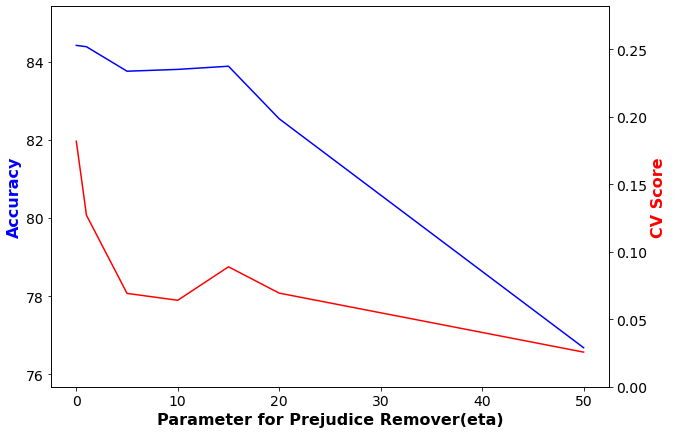

In [17]:
fairness_plot(eta_value,'Parameter for Prejudice Remover(eta)',acc,"Accuracy",cvs_score,"CV Score")

The plot above shows impact of different eta values on model performance and fairness.

It can be observed that the model fairness improves after induction of PRR into training, compared to baseline model.

## 5. Summary
 
In this tutorial, we have shown how to reduce the bias and force our model into making fair predictions by the `Prejudice Remover Regularizer` procedure (an in-processing technique). And yes, making fair predictions comes at a cost: it will reduce the performance of our model (hopefully, only by a little). However, in many cases, this will be a relatively small price to pay.

## References
1. Toshihiro Kamishima, Shotaro Akaho, Hideki Asoh & Jun Sakuma. "Fairness-aware classifier with prejudice remover regularizer." Joint European Conference on Machine Learning and Knowledge Discovery in Databases ECML PKDD 2012: Machine Learning and Knowledge Discovery in Databases pp 35–50.
2. Celis, L. Elisa, et al. "Classification with fairness constraints: A meta-algorithm with provable guarantees." Proceedings of the conference on fairness, accountability, and transparency. 2019.
3. Zhang, Brian Hu, Blake Lemoine, and Margaret Mitchell. "Mitigating unwanted biases with adversarial learning." Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society. 2018.
4. https://archive.ics.uci.edu/ml/datasets/Adult
5. Zafar, Muhammad Bilal, et al. "Fairness constraints: Mechanisms for fair classification." Artificial Intelligence and Statistics. PMLR, 2017.